# Virgo: exploratory data analysis

## Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [3]:
import datetime
from dateutil.relativedelta import relativedelta

## Transfomations

visualising stock data

In [4]:
def viz_data(stock_code, n_days, window, lags, plot = True, end_result = False):
    today = datetime.date.today()
    begin_date = today - relativedelta(days = n_days)
    begin_date_str = begin_date.strftime('%Y-%m-%d')

    stock = yf.Ticker(stock_code)
    df = stock.history(period="max")
    df = df.sort_values('Date')
    df.reset_index(inplace=True)

    ### getting rolling mean
    df["Close_roll_mean"] = (
        df.sort_values("Date")["Close"]
        .transform(lambda x: x.rolling(window, min_periods=1).mean())
    )

    ### getting rolling stdv
    df["Close_roll_std"] = (
        df.sort_values("Date")["Close"]
        .transform(lambda x: x.rolling(window, min_periods=1).std())
    )
    df["upper"] = df['Close_roll_mean'] + df["Close_roll_std"]*2
    df["lower"] = df['Close_roll_mean'] - df["Close_roll_std"]*2

    ### differencial analysis
    df['lag'] = df.Close.shift(lags)
    df['Dif'] = np.log(df['Close']) - np.log(df['lag'])
    df['Pos'] = np.where(df['Dif'] >= 0,df['Dif'], np.nan )
    df['Neg'] = np.where(df['Dif'] < 0,df['Dif'], np.nan )

    df = df[df.Date >= begin_date_str ]

    ### Plots
    if plot:
        fig = make_subplots(rows=2, cols=2,vertical_spacing = 0.1,shared_xaxes=True,
                           subplot_titles=(
                               f'stock: {stock_code} roll window analysis: {window} days', 
                                f'log return: {stock_code}, {n_days} days daily returns days',
                                f'stock: {stock_code} differencial: {lags} lags',
                                f'log return: {stock_code}, 14 days daily returns days')
                           )

        fig.add_trace(go.Scatter(x=df['Date'], y=df.Close, marker_color = 'blue', name='Price'),row=1, col=1)
        fig.add_trace(go.Scatter(x=df['Date'], y=df.Close_roll_mean, marker_color = 'grey', name='roll mean' ),row=1, col=1)
        fig.add_trace(go.Scatter(x=df['Date'], y=df.lower, marker_color = 'pink', name='bound' ),row=1, col=1)
        fig.add_trace(go.Scatter(x=df['Date'], y=df.upper, marker_color = 'pink', name='bound', showlegend=False ),row=1, col=1)

        fig.add_trace(go.Bar(x=df['Date'], y=df.Pos, marker_color = 'blue', showlegend=False ),row=2, col=1)
        fig.add_trace(go.Bar(x=df['Date'], y=df.Neg, marker_color = 'red', showlegend=False ),row=2, col=1)

        begin_date_week = today - relativedelta(days = 14)
        begin_date_week_str = begin_date_week.strftime('%Y-%m-%d')

        fig.add_trace(go.Histogram(x=df['Dif'], marker_color = 'blue', showlegend=False, nbinsx = 50 ),row=1, col=2)
        fig.add_trace(go.Histogram(x=df[df.Date >=  begin_date_week_str]['Dif'], marker_color = 'blue', showlegend=False, nbinsx = 20 ),row=2, col=2)

        fig.update_layout(height=900, width=1400, title_text=f"stock {stock_code} vizualization")
        fig.show()
    if end_result:
        return df

In [5]:
n_days = 350
window = 7
lags = 3

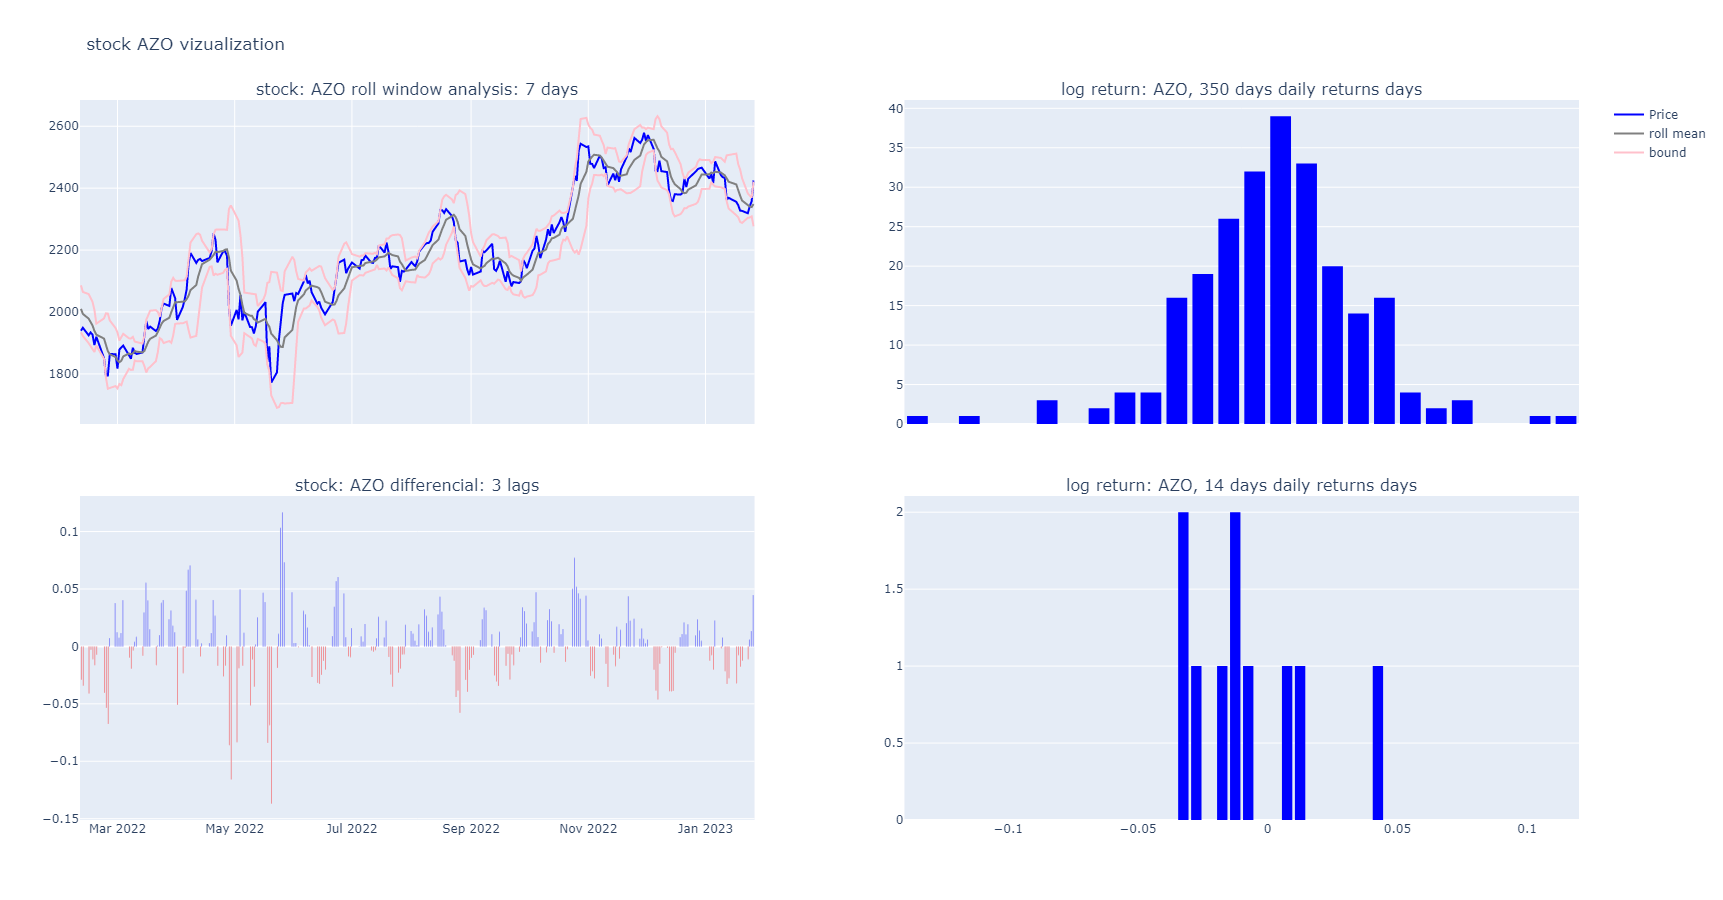

In [35]:
viz_data(stock_code = "AZO", n_days = n_days, window = window, lags = lags)

In [36]:
stocks_codes_ = ["PG", 'PEP'] + ['LMT','CI','CS','CL','AZO']

In [37]:
def shape_data(data, prefix, ref_price, std_column, logdif_column):
    data = data[['Date', ref_price, std_column, logdif_column]]
    data = data.rename(columns = {
        ref_price: f'{prefix}_price',
        std_column: f'{prefix}_stv',
        logdif_column: f'{prefix}_logdif',
    })
    return data

In [38]:
std_column = 'Close_roll_std'
ref_price = 'Close'
logdif_column = 'Dif'

In [39]:
data_collection = {}

for code in stocks_codes_:
    df = viz_data(stock_code = code, n_days = n_days, window = window, lags = lags, plot = False, end_result = True)
    df = shape_data(df, code, ref_price, std_column, logdif_column)
    data_collection[code] = df

In [40]:
df_i = data_collection[stocks_codes_[0]]
for i in stocks_codes_[1:]:
    df_i = df_i.merge(data_collection[i], on = 'Date', how = 'outer')
analysis_dataset = df_i

In [41]:
def data_corr_analysis(data):
    std_columns = [ x for x in data.columns if x.__contains__('_logdif')]
    data = data[ ['Date'] + std_columns]
    data = data.set_index('Date')
    return data

In [42]:
corr_data_base = data_corr_analysis(data = analysis_dataset )

In [43]:
def plot_correlation(data, n_days):
    
    today = datetime.date.today()
    begin_date = today - relativedelta(days = n_days)
    begin_date_str = begin_date.strftime('%Y-%m-%d')
    
    data = data[data.index >= begin_date_str]
    result = data.corr()

    a4_dims = (25.0, 10.0)
    fig, axes = plt.subplots(1,2,figsize=a4_dims)
    sns.heatmap(result , ax = axes[0], annot=True)
    
    begin_date_week = today - relativedelta(days = 7)
    begin_date_week_str = begin_date.strftime('%Y-%m-%d')
    data = data[data.index >= begin_date_week_str]
    result = data.corr()
    sns.heatmap(result , ax = axes[1], annot=True)

    #return result

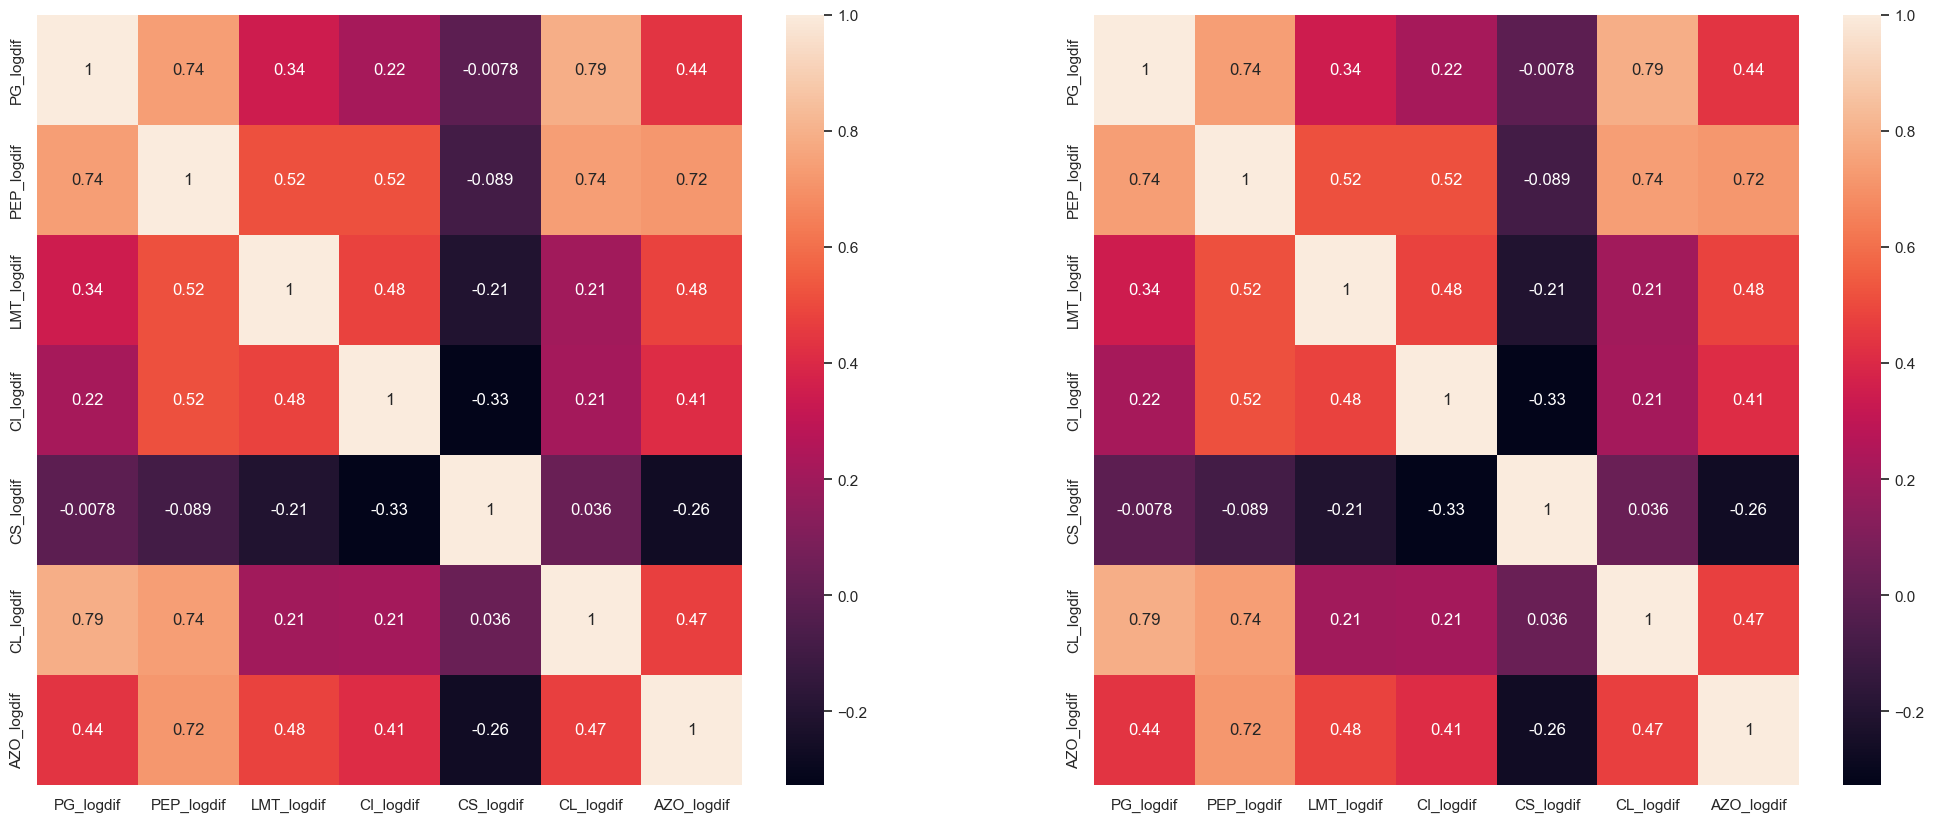

In [44]:
plot_correlation(data = corr_data_base, n_days = 100)

###  OtherMarket Datam

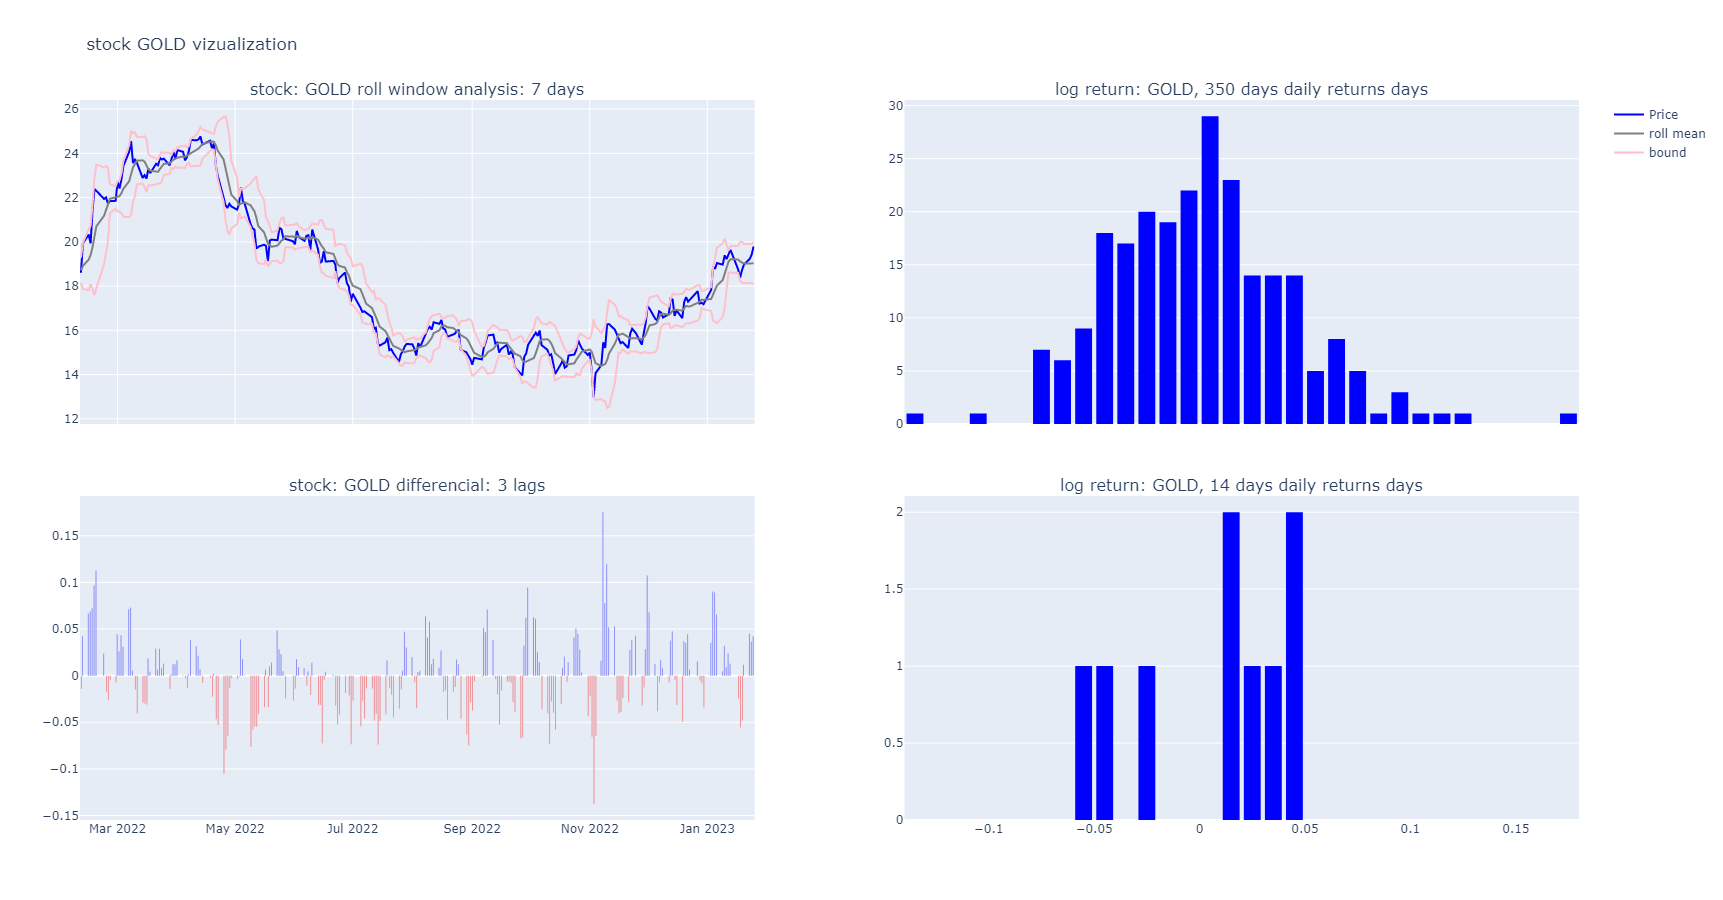

In [16]:
viz_data(stock_code = "GOLD", n_days = n_days, window = window, lags = lags)

Got error from yahoo api for ticker S&P500, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- S&P500: No timezone found, symbol may be delisted


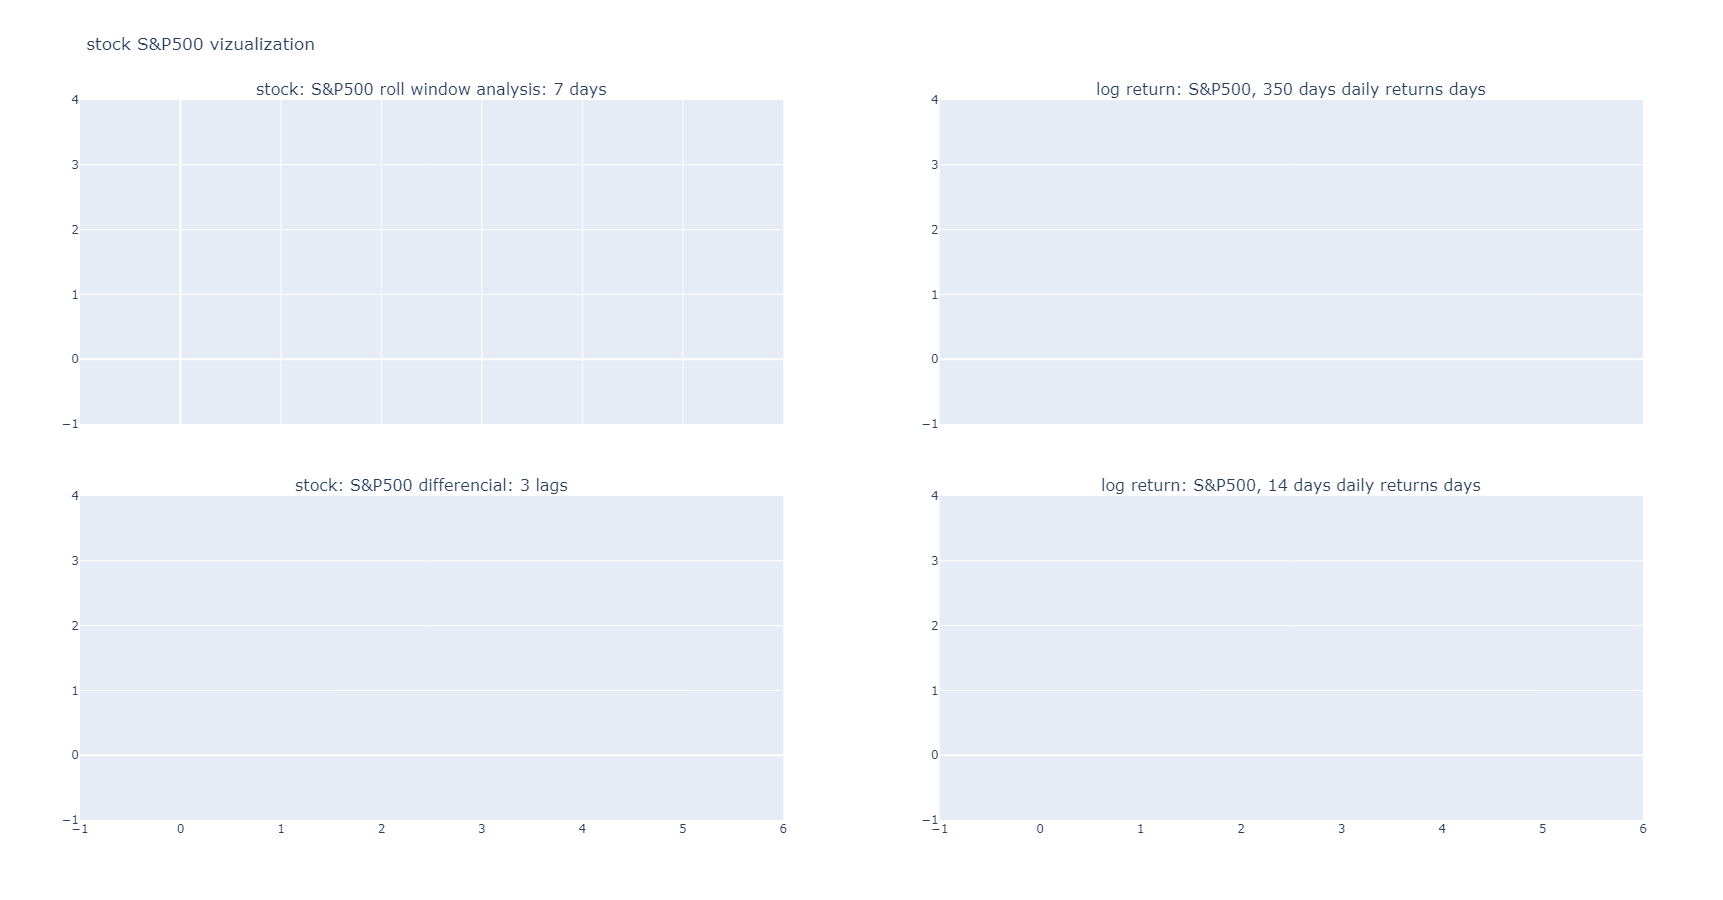

In [17]:
viz_data(stock_code = "S&P500", n_days = n_days, window = window, lags = lags)

In [18]:
tickerData = yf.Ticker('^GSPC')

In [19]:
tickerData

yfinance.Ticker object <^GSPC>

In [20]:
tickerDf1 = tickerData.history(period='1d', start='2010-1-1', end='2020-10-1')

In [21]:
tickerDf1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0
2010-01-05 00:00:00-05:00,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0
2010-01-06 00:00:00-05:00,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0
2010-01-07 00:00:00-05:00,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0
2010-01-08 00:00:00-05:00,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0
...,...,...,...,...,...,...,...
2020-09-24 00:00:00-04:00,3226.139893,3278.699951,3209.449951,3246.590088,4601920000,0.0,0.0
2020-09-25 00:00:00-04:00,3236.659912,3306.879883,3228.439941,3298.459961,3803330000,0.0,0.0
2020-09-28 00:00:00-04:00,3333.899902,3360.739990,3332.909912,3351.600098,3950910000,0.0,0.0
